# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Import necessary packages

In [101]:
import numpy as np
#import tensorflow
#import theano if you want to change backend
import keras
import idx2numpy
import os
import h5py

In [3]:
keras.backend.image_dim_ordering()

'tf'

For 2D data (e.g. image), "tf" assumes (rows, cols, channels) while "th" assumes (channels, rows, cols).
For 3D data, "tf" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while "th" assumes  (channels, conv_dim1, conv_dim2, conv_dim3).

In [4]:
#to find where to change backend for keras: "theano" or "tensorflow" in json file
#print(os.path.expanduser('~'))

In [5]:
print (np.__version__)
print (keras.__version__)

1.11.3
1.2.1


In [6]:
#import all the pieces of the neural network
from keras.models import Sequential, Model#the model
from keras.layers import Dense, Dropout, Activation, Flatten, Input #fully connected layers
from keras.layers import Convolution2D, MaxPooling2D #the convnet
from keras.utils import np_utils #extra tools
import idx2numpy # used to concatenate MNIST dataset so that it has 5 digits

In [7]:
np.random.seed(123)  # for reproducibility

## read in the data and create the synthetic dataset using idx2numpy and numpy.hstack

idx2numpy package provides a tool for converting files to and from
IDX format to numpy.ndarray.  the code below reads in the MNIST files downloaded here: http://yann.lecun.com/exdb/mnist/.  the files are read in as numpy arrays which is exactly what we need to feed the data to the neural net.  the goal is combine five different MNIST examples to create a multidigit sequence.  thus, the 
dataset size is the original train dataset divided by 5.  the image height remains the same but the width is 5 times as long since there are five images side by side.  for this, numpy has a great function called hstack that stacks arrays in sequence horizontally (column wise).  the MNIST data comes with labels and to create the new label we append them to a string within the loop after concatenating the images to return the new image and the new label.
        

In [8]:
# read data and convert idx file to numpy array
ndarr = idx2numpy.convert_from_file('train-images-idx3-ubyte')
labels_raw = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
dataset_size = ndarr.shape[0]/5
image_height = 28
image_width = (28*5) # five images long


def createSequences():
    dataset = np.ndarray(shape=(dataset_size, image_height, image_width),
                         dtype=np.float32)

    data_labels = []

    i = 0
    w = 0
    while i < dataset_size:
        temp = np.hstack(
            [ndarr[w], ndarr[w + 1], ndarr[w + 2], ndarr[w + 3], ndarr[w + 4]])
        dataset[i, :, :] = temp
        temp_str = (labels_raw[w], labels_raw[
                    w + 1], labels_raw[w + 2], labels_raw[w + 3], labels_raw[w + 4])
        data_labels.append(temp_str)
        w += 5
        i += 1

    np.array(data_labels)

    return dataset, data_labels


dataset, data_labels = createSequences()

/Users/juliadills/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## display the new dataset 

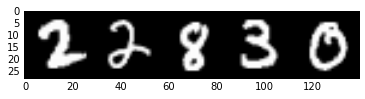

Label : (2, 2, 8, 3, 0)


In [9]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
def displaySequence(n):
    fig=plt.figure()
    plt.imshow(dataset[n], cmap='gray')
    plt.show()
    print ('Label : {}'.format(data_labels[n]))
    
#display random sample to check if data is ok after creating sequences
displaySequence(random.randint(0, dataset_size))

In [12]:
dataset=dataset[:,np.newaxis,:,:] 
#print a few things to make sure it looks good
print("size of one image:", dataset[0].shape)
print("dataset size:", dataset.shape)
print("length of labels array:", len(data_labels))
print("sample label:", data_labels[0])

size of one image: (1, 1, 1, 28, 140)
dataset size: (12000, 1, 1, 1, 28, 140)
length of labels array: 12000
sample label: (5, 0, 4, 1, 9)


## create train and test set from new dataset

In [14]:
from sklearn.cross_validation import train_test_split
y = data_labels
X = dataset

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

/Users/juliadills/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## additional preprocessing

1) the train and test must be numpy arrays 

2) each digit (the label) needs to be in a separate array to that it can be fed into the model

3) these new arrays must be encoded 

In [15]:
train_array= np.array(y_train)
test_array= np.array(y_test)
#unlike the traditional MNIST tutorials, we need to predict the concatenated image of 5 different numbers
#so I'm using numpy to create arrays for each number
#I'll then have to encode these
#train labels 
digit0=(train_array[:,0])
digit1=(train_array[:,1])
digit2=(train_array[:,2])
digit3=(train_array[:,3])
digit4=(train_array[:,4])
#do test labels as well 
digit0t=(test_array[:,0])
digit1t=(test_array[:,1])
digit2t=(test_array[:,2])
digit3t=(test_array[:,3])
digit4t=(test_array[:,4])

In [16]:
#encode train labels
tr_0 = np_utils.to_categorical(digit0, 10) #10 possible digits to encode 0-9
tr_1 = np_utils.to_categorical(digit1, 10)
tr_2 = np_utils.to_categorical(digit2, 10)
tr_3 = np_utils.to_categorical(digit3, 10)
tr_4 = np_utils.to_categorical(digit4, 10) 
#encode test labels
te_0 = np_utils.to_categorical(digit0t, 10)
te_1 = np_utils.to_categorical(digit1t, 10)
te_2 = np_utils.to_categorical(digit2t, 10)
te_3 = np_utils.to_categorical(digit3t, 10)
te_4 = np_utils.to_categorical(digit4t, 10)

In [17]:
#check that everything worked
print('X_train shape:', X_train.shape)
print('y_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(tr_3.shape, 'encoded training labels for digit 3')

X_train shape: (9600, 1, 1, 1, 28, 140)
y_train shape: (9600, 1, 1, 1, 28, 140)
9600 train samples
2400 test samples
(9600, 10) encoded training labels for digit 3


In [18]:
#data must be reshaped for tensorflow backend input
#keras backend image dim order is tf
X_train = X_train.reshape(X_train.shape[0], 28, 140, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 140, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 #normalize our data values to the range [0, 1], 255 is the max value of X_train.max()
X_test /= 255

## create the CNN using Keras

In [19]:
from keras.callbacks import ModelCheckpoint #may want to use checkpoint and save weights

In [20]:
filepath="weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [21]:
from keras.callbacks import History #may want to print history if set verbose to 0
history = History()

In [22]:
#THE MODEL#
batch_size = 128
nb_classes = 10
nb_epoch = 2

img_rows =28
img_cols=140
img_channels = 1

model_input=Input(shape=(img_rows, img_cols, img_channels))

x = Convolution2D(32, 3, 3, border_mode='same')(model_input)
x = Activation('relu')(x)
x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
conv_out = Flatten()(x)

x1 = Dense(nb_classes, activation='softmax')(conv_out)
x2 = Dense(nb_classes, activation='softmax')(conv_out)
x3 = Dense(nb_classes, activation='softmax')(conv_out)
x4 = Dense(nb_classes, activation='softmax')(conv_out)
x5 = Dense(nb_classes, activation='softmax')(conv_out)

lst = [x1, x2, x3, x4, x5]

#model = Model(input=model_input, output=lst)
model = Model(input=model_input, output=lst) #I learned you can't use a sequential model for this type of prediction

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

model.fit(X_train, [tr_0, tr_1, tr_2, tr_3, tr_4], batch_size=batch_size, nb_epoch=nb_epoch, callbacks=[history],verbose=1)
#set verbose to 0 if you run many, many epochs and don't want a huge printout

Epoch 1/2
9600/9600 [==============================] - 138s - loss: 4.4107 - dense_1_loss: 0.8733 - dense_2_loss: 0.8700 - dense_3_loss: 0.8499 - dense_4_loss: 0.8804 - dense_5_loss: 0.9371 - dense_1_acc: 0.7168 - dense_2_acc: 0.7151 - dense_3_acc: 0.7251 - dense_4_acc: 0.7109 - dense_5_acc: 0.6969   
Epoch 2/2
9600/9600 [==============================] - 126s - loss: 1.4280 - dense_1_loss: 0.2768 - dense_2_loss: 0.2653 - dense_3_loss: 0.2668 - dense_4_loss: 0.3123 - dense_5_loss: 0.3068 - dense_1_acc: 0.9143 - dense_2_acc: 0.9175 - dense_3_acc: 0.9191 - dense_4_acc: 0.9018 - dense_5_acc: 0.9077   


In [23]:
#here we see the list of outputs for the pixels of each concatenated MNIST image
#five digits, five lists
model.output

[<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Softmax_1:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Softmax_2:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Softmax_3:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Softmax_4:0' shape=(?, 10) dtype=float32>]

In [ ]:
#print(history.history)
#looks like history tells you same thing verbose does

## use model to predict labels of test dataset

In [24]:
Y_pred = model.predict(X_test)
pred_array= np.array(Y_pred)#the output is a list but we need an array for the custom accuracy metric

## evaluate model using out of the box metric and custom accuracy metric

In [25]:
y_Test = [te_0, te_1, te_2, te_3, te_4]
score = model.evaluate(X_test, y_Test, verbose=0)
#print('Test score:', score[0])
print('Test accuracy:', score[1])

Test accuracy: 0.271629476547


### custom accuracy metric
This is an improvement I made after my first submission to Udacity.  
The out of the box accuracy is calculating if the entire sequence is correct.
The custom accuracy looks at the individual digits. 

In [26]:
def new_accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] 
          / predictions.shape[0])

#np.argmax() is the letter that got the highest "vote" from the model.  it's the prediction digit.

In [28]:
custom_accuracy = new_accuracy(pred_array, test_array)
print('accuracy of individual digits:', custom_accuracy)


accuracy of individual digits: 91.75


In [29]:
#take a look at what was predicted vs the actual labels
for n in range (0,10):
    print('predicted digits:', Y_pred[0][n].argmax(), Y_pred[1][n].argmax(), Y_pred[2][n].argmax(), Y_pred[3][n].argmax(), Y_pred[4][n].argmax())
    print('actual digits:', y_test[n])
    print('---------------------------')

predicted digits: 4 6 9 5 4
actual digits: (7, 6, 9, 5, 4)
---------------------------
predicted digits: 3 8 6 2 3
actual digits: (3, 8, 6, 2, 3)
---------------------------
predicted digits: 3 0 7 4 9
actual digits: (3, 0, 7, 4, 9)
---------------------------
predicted digits: 4 8 1 1 2
actual digits: (4, 8, 2, 1, 2)
---------------------------
predicted digits: 1 7 7 1 9
actual digits: (1, 7, 7, 1, 4)
---------------------------
predicted digits: 2 2 9 8 4
actual digits: (2, 2, 9, 8, 4)
---------------------------
predicted digits: 7 5 3 7 0
actual digits: (9, 5, 3, 7, 0)
---------------------------
predicted digits: 6 8 7 9 8
actual digits: (6, 8, 7, 9, 8)
---------------------------
predicted digits: 1 0 1 7 4
actual digits: (1, 0, 1, 7, 4)
---------------------------
predicted digits: 1 1 3 3 0
actual digits: (1, 1, 3, 5, 0)
---------------------------


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 
First, I did an MNIST tutorial: https://elitedatascience.com/keras-tutorial-deep-learning-in-python 

Second, I researched and read the forum to figure out the best way to concatenate the MNIST images, and it looked like the package idx2numpy was the best idea.

Third, I was stumped for a few days just figuring out to input the data to the neural net.  I realized to have the model output 5 different predictions I needed the data_labels to be a list of numpy arrays of length 5. Each of the numpy arrays then had to be encoded to have 10 different classes (ex. the number 3 would not be '3' but '0010000000'.

Fourth, I also found out that a sequential model in Keras would not work either, but one can just do from keras.models import Model.

Fifth, I modeled the code in Keras off of tutorials that existed for Cifar 10, MNIST, and other image classifications. 

Sixth, I trained the model with 12 epochs, which was computatinally expensive but did not produce better results than 2 epochs.   



### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
This model has the architecture [INPUT - CONV - RELU - CONV - RELU - POOL - FC]

INPUT [28x140x1] will hold the raw pixel values of the image

CONV layer -  slides a filter (kernel) over the image and computes a dot product between their weights and the target pattern (a small region they are connected to in the input volume). This may result in volume such as [28x140x32] if we decided to use 32 filters. 

RELU layer - replaces all negative pixel values in the feature map with zero. This is a non-linear function and is helpful because real world data is usually not linear. This layer leaves the size of the volume unchanged([28x140x32]).

POOL layer - will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [14x70x32].

The cycles of conv and relu make the neural net wider.  Multiple stacked CONV layers can develop more complex features before the pooling reduces the data.

FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of MNIST (numbers 0-9).

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**  I used a package idx2numpy to concatenate the images - that part is explained above. I did reset the axis previously so re-running the below code is necessary to view the synthetic dataset.

The model was trained and evaluated using the test set.  I used a function in sklearn to split the data into train and test. The most difficult part was figuring out how to get the model to output a list because many of the examples online are showing one classification per image and not five as in this exercise.

In [30]:
# read data and convert idx file to numpy array
ndarr = idx2numpy.convert_from_file('train-images-idx3-ubyte')
labels_raw = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
dataset_size = ndarr.shape[0]/5
image_height = 28
image_width = (28*5) # five images long


def createSequences():
    dataset = np.ndarray(shape=(dataset_size, image_height, image_width),
                         dtype=np.float32)

    data_labels = []

    i = 0
    w = 0
    while i < dataset_size:
        temp = np.hstack(
            [ndarr[w], ndarr[w + 1], ndarr[w + 2], ndarr[w + 3], ndarr[w + 4]])
        dataset[i, :, :] = temp
        temp_str = (labels_raw[w], labels_raw[
                    w + 1], labels_raw[w + 2], labels_raw[w + 3], labels_raw[w + 4])
        data_labels.append(temp_str)
        w += 5
        i += 1

    np.array(data_labels)

    return dataset, data_labels


dataset, data_labels = createSequences()

/Users/juliadills/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


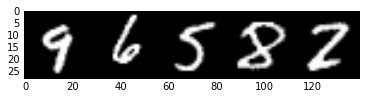

Label : (9, 6, 5, 8, 2)


In [31]:
#display random sample to check if data is ok after creating sequences
displaySequence(random.randint(0, dataset_size))

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## download SVHN data

In [ ]:
print('Downloading data...')

url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename)
    print('Download Complete!')
  statinfo = os.stat(filename)
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')
#extra_filename = maybe_download('extra.tar.gz')

print('Successfully downloaded data!')


# Unzip Data
print('Unzipping data...')
np.random.seed(8)

def maybe_extract(filename, force=False):
  # Remove .tar.gz
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = root
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
#extra_folders = maybe_extract(extra_filename)

print('Successfully unzipped data!')

## Create dictionary of bounding boxes

In [95]:
print('Creating dictionary of bounding boxes...')
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox
    
    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result
    
print("Successfully created dictionary of bounding boxes!")

Creating dictionary of bounding boxes...
Successfully created dictionary of bounding boxes!


## Get Digit Structure

In [102]:
print('Getting digit structure for training data...')
digitFileTrain=DigitStructFile(os.path.join('train','digitStruct.mat'))
train_data=digitFileTrain.getAllDigitStructure_ByDigit()
print('Success!')

print('Getting digit structure for test data...')
digitFileTest=DigitStructFile(os.path.join('test','digitStruct.mat'))
test_data=digitFileTest.getAllDigitStructure_ByDigit()
print('Success!')

Getting digit structure for training data...
Success!
Getting digit structure for test data...
Success!


## crop training and test images 

In [ ]:
# Crop Training Images
print('Cropping training images...')
train_imsize = np.ndarray([len(train_data),2])
for i in np.arange(len(train_data)):
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    im = Image.open(fullname)
    train_imsize[i, :] = im.size[:]

print('Success!')

# Crop Test Images
print('Cropping test images...')
test_imsize = np.ndarray([len(test_data),2])
for i in np.arange(len(test_data)):
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]

print('Success!')

## generate dataset using bounding boxes and resize to 32pixels by 32pixels

In [ ]:
import PIL.Image as Image

def generate_dataset(data, folder):

    dataset = np.ndarray([len(data),32,32,1], dtype='float32')
    labels = np.ones([len(data),6], dtype=int) * 10
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        labels[i,0] = num_digit
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: labels[i,j+1] = 0
            else: print('#',i,'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        im_top = np.floor(im_top - 0.1 * im_height//1)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])

        im = im.crop((int(im_left), int(im_top), int(im_right), int(im_bottom))).resize([32,32], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        dataset[i,:,:,:] = im[:,:,:]

    return dataset, labels

train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

In [ ]:
#delete if more than 5 digits
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)
print(train_dataset.shape, train_labels.shape)

## shuffle the dataset

In [ ]:
import random

random.seed(123)

n_labels = 10
valid_index = []
#valid_index2 = []
train_index = []
#train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())
    #valid_index2.extend(np.where(extra_labels[:,1] == (i))[0][:200].tolist())
    #train_index2.extend(np.where(extra_labels[:,1] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
#random.shuffle(valid_index2)
#random.shuffle(train_index2)

valid_dataset = train_dataset[valid_index,:,:,:]
valid_labels = train_labels[valid_index,:]
train_dataset_t = train_dataset[train_index,:,:,:]
train_labels_t = train_labels[train_index,:]

print(train_dataset_t.shape, train_labels_t.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

## pickle the datasets 
this will save a lot of time later on!

In [ ]:
pickle_file = 'SVHN_multi.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_t,
    'train_labels': train_labels_t,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

## load in the SVHN dataset pickle file

In [33]:
from six.moves import cPickle as pickle
pickle_file = 'SVHN_multi.pickle copy' #using a copy but otherwise the file is just SVHN_multi.pickle

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (29717, 32, 32, 1) (29717, 6)
Validation set (3684, 32, 32, 1) (3684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [36]:
from scipy.stats import itemfreq

In [37]:
#look at label frequency
itemfreq(train_labels[:,5])
#maybe we don't need this 6th softmax to predict a 6th digit since most are 10 meaning no number exists in that position

array([[    0,     1],
       [    1,     2],
       [    3,     1],
       [    5,     1],
       [    7,     2],
       [    9,     1],
       [   10, 29709]])

## create the label arrays and encode

In [38]:
#for the model, the arrays must be created and encoded as before
digit02=(train_labels[:,0])
digit12=(train_labels[:,1])
digit22=(train_labels[:,2])
digit32=(train_labels[:,3])
digit42=(train_labels[:,4])
digit52=(train_labels[:,5]) 

digit0t2=(test_labels[:,0])
digit1t2=(test_labels[:,1])
digit2t2=(test_labels[:,2])
digit3t2=(test_labels[:,3])
digit4t2=(test_labels[:,4])
digit5t2=(test_labels[:,5])

In [39]:
#encoding
tr_02 = np_utils.to_categorical(digit02, 11)#11 classes, not 10 like before
tr_12 = np_utils.to_categorical(digit12, 11)
tr_22 = np_utils.to_categorical(digit22, 11)
tr_32 = np_utils.to_categorical(digit32, 11)
tr_42 = np_utils.to_categorical(digit42, 11) 
tr_52 = np_utils.to_categorical(digit52, 11) 

te_02 = np_utils.to_categorical(digit0t2, 11)
te_12 = np_utils.to_categorical(digit1t2, 11)
te_22 = np_utils.to_categorical(digit2t2, 11)
te_32 = np_utils.to_categorical(digit3t2, 11)
te_42 = np_utils.to_categorical(digit4t2, 11) 
te_52 = np_utils.to_categorical(digit5t2, 11) 

## feed SVHN data into neural net 

In [59]:
batch_size2 = 128
nb_classes2 = 11 #change number of classes
nb_epoch2 = 2

img_rows2 =32 #change input size
img_cols2=32
img_channels2 = 1 #data is grayscale, preprocessed this way

model_input2=Input(shape=(img_rows2, img_cols2, img_channels2))

x2 = Convolution2D(32, 3, 3, border_mode='same')(model_input2)
x2 = Activation('relu')(x2)
x2 = Convolution2D(32, 3, 3)(x2)
x2 = Activation('relu')(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Dropout(0.25)(x2)
conv_out2 = Flatten()(x2)

x12 = Dense(nb_classes2, activation='softmax')(conv_out2)
x22 = Dense(nb_classes2, activation='softmax')(conv_out2)
x32 = Dense(nb_classes2, activation='softmax')(conv_out2)
x42 = Dense(nb_classes2, activation='softmax')(conv_out2)
x52 = Dense(nb_classes2, activation='softmax')(conv_out2)
x62 = Dense(nb_classes2, activation='softmax')(conv_out2)

lst2 = [x12, x22, x32, x42, x52, x62]

#model = Model(input=model_input, output=lst)
model2 = Model(input=model_input2, output=lst2)

model2.compile(loss='categorical_crossentropy',
optimizer='Adam', #switch btwn sgd and adam
metrics=['accuracy'])

model2.fit(train_dataset,[tr_02, tr_12, tr_22, tr_32, tr_42, tr_52], batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

Epoch 1/2
29717/29717 [==============================] - 108s - loss: 4.5676 - dense_42_loss: 0.5171 - dense_43_loss: 1.2282 - dense_44_loss: 1.6286 - dense_45_loss: 0.9277 - dense_46_loss: 0.2481 - dense_47_loss: 0.0180 - dense_42_acc: 0.8023 - dense_43_acc: 0.5934 - dense_44_acc: 0.4686 - dense_45_acc: 0.7456 - dense_46_acc: 0.9538 - dense_47_acc: 0.9966   
Epoch 2/2
29717/29717 [==============================] - 109s - loss: 2.7634 - dense_42_loss: 0.2737 - dense_43_loss: 0.7089 - dense_44_loss: 1.0731 - dense_45_loss: 0.5779 - dense_46_loss: 0.1255 - dense_47_loss: 0.0043 - dense_42_acc: 0.9043 - dense_43_acc: 0.7813 - dense_44_acc: 0.6683 - dense_45_acc: 0.8307 - dense_46_acc: 0.9674 - dense_47_acc: 0.9997   


In [ ]:
#to use to switch optimizer
#from keras.optimizers import SGD
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

## predict

In [60]:
ypred_svhn = model2.predict(test_dataset)
pred_array_svhn= np.array(ypred_svhn)#create array for the custom accuracy calculation

In [61]:
test_array_svhn= np.array(test_labels)

In [62]:
custom_accuracy_svhn = new_accuracy(pred_array_svhn, test_array_svhn)
print("digit prediction accuracy:", custom_accuracy_svhn)

digit prediction accuracy: 86.6697275788


In [63]:
for n in range (0,10):
    print('predicted digits:', ypred_svhn[0][n].argmax(), ypred_svhn[1][n].argmax(), ypred_svhn[2][n].argmax(), ypred_svhn[3][n].argmax(), ypred_svhn[4][n].argmax(), ypred_svhn[5][n].argmax())
    print('actual digits:', test_labels[n])
    print('---------------------------')

predicted digits: 1 5 10 10 10 10
actual digits: [ 1  5 10 10 10 10]
---------------------------
predicted digits: 3 2 1 10 10 10
actual digits: [ 3  2  1  0 10 10]
---------------------------
predicted digits: 2 6 7 10 10 10
actual digits: [ 1  6 10 10 10 10]
---------------------------
predicted digits: 1 1 10 10 10 10
actual digits: [ 1  1 10 10 10 10]
---------------------------
predicted digits: 1 1 10 10 10 10
actual digits: [ 1  9 10 10 10 10]
---------------------------
predicted digits: 1 1 10 10 10 10
actual digits: [ 1  1 10 10 10 10]
---------------------------
predicted digits: 3 1 9 3 10 10
actual digits: [ 3  1  8  3 10 10]
---------------------------
predicted digits: 2 1 1 10 10 10
actual digits: [ 2  6  5 10 10 10]
---------------------------
predicted digits: 3 1 4 4 10 10
actual digits: [ 3  1  4  4 10 10]
---------------------------
predicted digits: 2 1 6 10 10 10
actual digits: [ 2  1  6 10 10 10]
---------------------------


In [64]:
y_Test2 = [te_02, te_12, te_22, te_32, te_42, te_52]
score = model2.evaluate(test_dataset, y_Test2, verbose=0)
#print('Test score:', score[0])
print('Test accuracy:', score[1])

Test accuracy: 0.30649560791


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** Model input changed slightly to fit the new dataset becaues the image dimensions are 32x32 and not 28x140 pixels.  Another dense layer was added for the extra class (the shape of the labels was 6 not 5).  The number of classes increased to 11 (the possibility that there is not a number because all of the dataset does not have exactly five digits as before, this null is represented as 10, so we have numbers 0-10 or 11 classes).

Overall the model performed better than I expected on this new dataset.  The model was trained on the dataset itself (it wasn't trained on the MNIST data but is the same model structure) but I still expected the complexity of the images in SVHN to cause it to perform much worse.  SVHN has raised block letters, different number positions, and image backgrounds that could confuse the model.  


### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** Most of the work done was preprocessing the data - getting the bounding boxes, cropping the images, changing to grayscale,getting the arrays in the correct shape for the model.  

I tried changing the optimizer from "Adam" to "SGD". "Adam" performed much better with a custom accuracy about 30% higher.  84% vs 54%.

I tried changing the learning rate but saw no huge improvement over the defaults within the Adam optimizer
keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

I noticed that when I ran the model for 12 epochs, the accuracy was lower.  This is likely overfitting.  

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**  My initial try with SVHN had a test accuracy of less than .15.  My second try was 0.25.  Introducing the custom accuracy calculation and printing the predictions to compare made me feel much better about it - at first I wasn't sure it worked at all!

If we judge the model by the digit accuracy (custom accuracy metric) I do believe it does a good enough job at classifying the numbers.  However, it is not great at classifying the entire sequence.  I read many forums and stack overflow posts and it seems classifying the sequence eludes many.  A very simple tutorial can have you classifying single digit MNIST with over 95% accuracy, but a sequence of numbers must pose challenges that are outside the scope of what I currently know.

Goodfellow et al., produced a whole-sequence transcription accuracy of ~96% on the public SVHN dataset [https://arxiv.org/pdf/1312.6082v4.pdf].  Definitely amazed and in awe of their research!

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## define function to convert to grayscale

In [65]:
def rgb2gray(rgb): #svhn images were set to grayscale before training model, so doing the same here
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

## read in images

In [66]:
import glob
import matplotlib.image as img


new_images=[]

for image_path in glob.glob("new images/*.jpg"):
    image = img.imread(image_path)
    image = rgb2gray(image)
    #print (image.shape)
    #print (image.dtype)
    new_images.append(image)

In [67]:
len(new_images)
#i added 17 new images

17

### define function to display the new images

In [69]:
def displaySequence2(n):
    fig=plt.figure()
    plt.imshow(new_images[n], cmap='gray')
    plt.show()

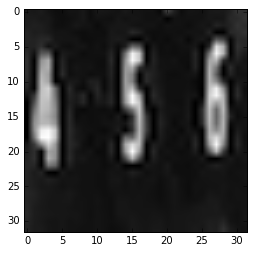

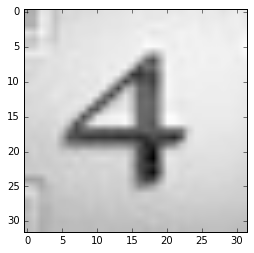

In [72]:
displaySequence2(15)
displaySequence2(12)

In [74]:
#images are the pixel shape we need
new_images[0].shape

(32, 32)

### reshape images for input into the model

In [75]:
reshaped=[]
for image in new_images:
    image = image.reshape(image.shape[1],32, 1)#had 2 in there image.shape[2],32,32, 1
    image.astype(float)
    reshaped.append(image)

In [76]:
reshaped=np.array(reshaped)
reshaped2= reshaped.reshape(reshaped.shape[0], 32, 32, 1)
reshaped2.shape

(17, 32, 32, 1)

## predict the model on new images from real world

In [77]:
preds_real = model2.predict(reshaped2)

In [78]:
array_preds_real=np.array(preds_real)

## create array of labels for new images

In [89]:
labels_array = np.array([[4,5,7,0,10,10],[6,5,10,10,10,10],[9,3,10,10,10,10],[3,4,10,10,10,10],[4,6,10,10,10,10],[5,1,7,10,10,10],[1,2,3,10,10,10],[5,10,10,10,10,10],[8,1,5,10,10,10],[1,0,1,1,10,10],[1,1,1,3,10,10],[1,3,4,1,10,10],[4,10,10,10,10,10],[9,1,6,10,10,10],[2,10,10,10,10,10],[4,5,6,10,10,10],[0,0,0,10,10,10]])

In [90]:
custom_accuracy_real = new_accuracy(array_preds_real, labels_array)
custom_accuracy_real

56.86274509803922

In [82]:
for n in range (0,17):
    print('predicted digits:', preds_real[0][n].argmax(), preds_real[1][n].argmax(), preds_real[2][n].argmax(), preds_real[3][n].argmax(), preds_real[4][n].argmax())
    print('actual digits:', labels_array[n])
    print('---------------------------')

predicted digits: 2 1 7 10 10
actual digits: [ 4  5  7  0 10]
---------------------------
predicted digits: 2 1 10 10 10
actual digits: [ 6  5 10 10 10]
---------------------------
predicted digits: 2 2 8 10 10
actual digits: [ 9  3 10 10 10]
---------------------------
predicted digits: 2 2 4 10 10
actual digits: [ 3  4 10 10 10]
---------------------------
predicted digits: 2 1 6 10 10
actual digits: [ 4  6 10 10 10]
---------------------------
predicted digits: 3 5 7 10 10
actual digits: [ 5  1  7 10 10]
---------------------------
predicted digits: 1 1 10 10 10
actual digits: [ 1  2  3 10 10]
---------------------------
predicted digits: 1 2 5 10 10
actual digits: [ 5 10 10 10 10]
---------------------------
predicted digits: 2 1 1 10 10
actual digits: [ 8  1  5 10 10]
---------------------------
predicted digits: 3 1 1 8 10
actual digits: [ 1  0  1  1 10]
---------------------------
predicted digits: 2 1 4 10 10
actual digits: [ 1  1  1  3 10]
---------------------------
predicted

The custom accuracy is much lower than SVHN but this makes sense because we are predicting on completely new data.  I thought the images I chose were similar enough, but this may not be the case.  The model seems to predict the absense of a digit better than digits 0-9.

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

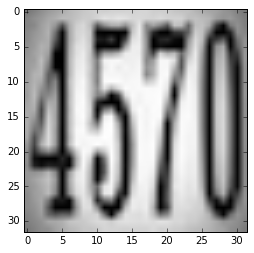

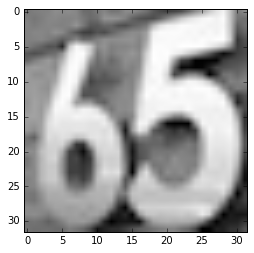

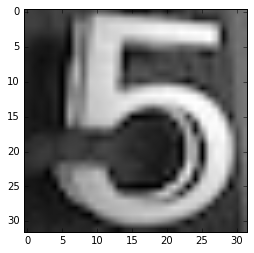

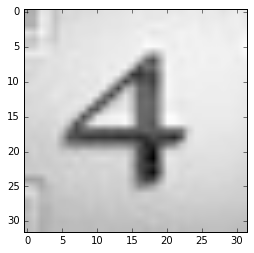

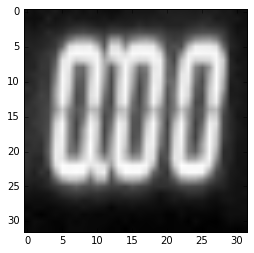

In [93]:
displaySequence2(0)
displaySequence2(1)
displaySequence2(7)
displaySequence2(12)
displaySequence2(16)


**Answer:** 

Image 1 - the numbers in this image seem highly predictable and the background does not have detail

Image 2 - the brick in the background could make it harder to predict

Image 3 - this is a raised block letter and that could be harder to predict

Image 4 - detail in the top left and bottom left corner could cause the model to read an edge and throw off the prediction

Image 5 - the ':' in the image could throw off the prediction

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:** 
No, it is not.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [103]:
#I already created the localization and got the bounding boxes 
#the dataset came with character level bounding boxes stored in digitStruct.mat when you download it
#I've printed some information below on the bounding boxes
print(digitFileTrain)
dir(DigitStructFile)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bboxHelper',
 'getAllDigitStructure',
 'getAllDigitStructure_ByDigit',
 'getBbox',
 'getDigitStructure',
 'getName']

In [110]:
inf = 'test/digitStruct.mat'
file = h5py.File(inf, 'r')
digitStructName = file['digitStruct']['name']
digitStructBbox = file['digitStruct']['bbox']

In [117]:
digitStructBbox.shape

(13068, 1)

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**
Localization using the bounding boxes was performed when preparing the dataset to be pickled.  When I tried without localization the performance was so bad that I included it before this step.  The first week I worked on this I was very unsure about the model's ability to learn and tried as many suggested actions as possible, including this part.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.